In [41]:
import os
import json
import numpy as np
import pandas as pd
from tqdm import tqdm
from copy import deepcopy
from pprint import pprint
import glob
import spacy
from spacy.matcher import PhraseMatcher

In [14]:
data = "/home/varun/Task/2020-04-10/biorxiv_medrxiv/pdf_json/"
filenames = os.listdir(data)
print(len(filenames))

1625


In [15]:
all_files = []
for filename in filenames:
    filename = data + filename
    file = json.load(open(filename, 'rb'))
    all_files.append(file)
file = all_files[0]
print("Dictionary keys:", file.keys())

Dictionary keys: dict_keys(['paper_id', 'metadata', 'abstract', 'body_text', 'bib_entries', 'ref_entries', 'back_matter'])


In [16]:
print("body_text content:")
pprint(file['body_text'][:2], depth=3)

body_text content:
[{'cite_spans': [{...}, {...}, {...}],
  'ref_spans': [],
  'section': 'Introduction',
  'text': 'On December 31, 2019, the World Health Organization (WHO) was '
          'alerted about a cluster of pneumonia of unknown aetiology in the '
          'city of Wuhan, China [1] . Only a few days later, Chinese '
          'authorities identified and characterised a novel coronavirus '
          '(2019-nCoV) as the causative agent of the outbreak [2] . The '
          'outbreak apparently started from a single or multiple zoonotic '
          'transmission events at a wet market in Wuhan, and has since '
          'resulted in 655 confirmed cases in China and several other '
          'countries by January 23, 2020 [3] . At this early stage of the '
          'outbreak, it is critically important to gain a better understanding '
          'of the transmission pattern and the potential for sustained '
          'human-to-human transmission of 2019-nCoV. Information on the

In [17]:
texts = [(di['section'], di['text']) for di in file['body_text']]
texts_di = {di['section']: "" for di in file['body_text']}
for section, text in texts:
    texts_di[section] += text

pprint(list(texts_di.keys()))

['Introduction', 'Methods', 'Results']


In [18]:
body = ""

for section, text in texts_di.items():
    body += section
    body += "\n\n"
    body += text
    body += "\n\n"

print(body[:3000])

Introduction

On December 31, 2019, the World Health Organization (WHO) was alerted about a cluster of pneumonia of unknown aetiology in the city of Wuhan, China [1] . Only a few days later, Chinese authorities identified and characterised a novel coronavirus (2019-nCoV) as the causative agent of the outbreak [2] . The outbreak apparently started from a single or multiple zoonotic transmission events at a wet market in Wuhan, and has since resulted in 655 confirmed cases in China and several other countries by January 23, 2020 [3] . At this early stage of the outbreak, it is critically important to gain a better understanding of the transmission pattern and the potential for sustained human-to-human transmission of 2019-nCoV. Information on the transmission characteristics will help coordinate current screening and containment strategies, support decision making on whether the outbreak constitutes a public health emergency of international concern (PHEIC), and is necessary for anticipa

In [19]:
#Seeing keys cobntained in metadata
print(all_files[0]['metadata'].keys())

dict_keys(['title', 'authors'])


In [20]:
#Seeing the title
all_files[0]['metadata']['title']

'A PREPRINT'

In [21]:
#printing the authors
authors = all_files[0]['metadata']['authors']
authors[:3]

[{'first': 'Julien',
  'middle': [],
  'last': 'Riou',
  'suffix': '',
  'affiliation': {'laboratory': '',
   'institution': 'University of Bern Bern',
   'location': {'country': 'Switzerland'}},
  'email': 'julien.riou@ispm.unibe.ch'},
 {'first': 'Christian',
  'middle': ['L'],
  'last': 'Althaus',
  'suffix': '',
  'affiliation': {'laboratory': '',
   'institution': 'University of Bern',
   'location': {'settlement': 'Bern', 'country': 'Switzerland'}},
  'email': 'christian.althaus@alumni.ethz.ch'}]

In [22]:
def format_name(author):
    middle_name = " ".join(author['middle'])
    
    if author['middle']:
        return " ".join([author['first'], middle_name, author['last']])
    else:
        return " ".join([author['first'], author['last']])

In [23]:
def format_affiliation(affiliation):
    text = []
    location = affiliation.get('location')
    if location:
        text.extend(list(affiliation['location'].values()))
    
    institution = affiliation.get('institution')
    if institution:
        text = [institution] + text
    return ", ".join(text)

In [24]:
def format_authors(authors, with_affiliation=False):
    name_ls = []
    
    for author in authors:
        name = format_name(author)
        if with_affiliation:
            affiliation = format_affiliation(author['affiliation'])
            if affiliation:
                name_ls.append(f"{name} ({affiliation})")
            else:
                name_ls.append(name)
        else:
            name_ls.append(name)
    
    return ", ".join(name_ls)

In [25]:
def format_body(body_text):
    texts = [(di['section'], di['text']) for di in body_text]
    texts_di = {di['section']: "" for di in body_text}
    
    for section, text in texts:
        texts_di[section] += text

    body = ""

    for section, text in texts_di.items():
        body += section
        body += "\n\n"
        body += text
        body += "\n\n"
    
    return body

In [26]:
def format_bib(bibs):
    if type(bibs) == dict:
        bibs = list(bibs.values())
    bibs = deepcopy(bibs)
    formatted = []
    
    for bib in bibs:
        bib['authors'] = format_authors(
            bib['authors'], 
            with_affiliation=False
        )
        formatted_ls = [str(bib[k]) for k in ['title', 'authors', 'venue', 'year']]
        formatted.append(", ".join(formatted_ls))

    return "; ".join(formatted)

In [27]:
for author in authors:
    print("Name:", format_name(author))
    print("Affiliation:", format_affiliation(author['affiliation']))
    print()

Name: Julien Riou
Affiliation: University of Bern Bern, Switzerland

Name: Christian L Althaus
Affiliation: University of Bern, Bern, Switzerland



In [28]:
#formating authors
authors = all_files[4]['metadata']['authors']
print("Formatting without affiliation:")
print(format_authors(authors, with_affiliation=False))
print("\nFormatting with affiliation:")
print(format_authors(authors, with_affiliation=True))

Formatting without affiliation:
Zeqing Feng, Bo Diao, Rongshuai Wang, Gang Wang, Chenhui Wang, Yingjun Tan, Liang Liu, Changsong Wang, Ying Liu, Yueping Liu, Zilin Yuan, Ren Liang, Yuzhang 3#,  Wu, Yongwen Chen

Formatting with affiliation:
Zeqing Feng (Third Military Medical University, 400038, Chongqing, People's Republic of China), Bo Diao (General Hospital of Central Theater Command, Hubei province, 430015, Wuhan, People's Republic of China), Rongshuai Wang (Hubei Chongxin Judicial Expertise Center, Hubei province, 430415, Wuhan, People's Republic of China), Gang Wang (General Hospital of Central Theater Command, Hubei province, 430015, Wuhan, People's Republic of China), Chenhui Wang (Third Military Medical University, 400038, Chongqing, People's Republic of China), Yingjun Tan (General Hospital of Central Theater Command, Hubei province, 430015, Wuhan, People's Republic of China), Liang Liu (Huazhong University of Science and Technology, No. 13 Hangkong Road, Hubei province, 4300

In [29]:
bibs = list(file['bib_entries'].values())
pprint(bibs[:2], depth=4)

[{'authors': [{'first': 'Zheng-Li', 'last': 'Shi', 'middle': [], 'suffix': ''},
              {'first': 'Peng', 'last': 'Zhou', 'middle': [], 'suffix': ''},
              {'first': 'Xing-Lou', 'last': 'Yang', 'middle': [], 'suffix': ''},
              {'first': 'Xian-Guang',
               'last': 'Wang',
               'middle': [],
               'suffix': ''},
              {'first': 'Ben', 'last': 'Hu', 'middle': [], 'suffix': ''},
              {'first': 'Lei', 'last': 'Zhang', 'middle': [], 'suffix': ''},
              {'first': 'Wei', 'last': 'Zhang', 'middle': [], 'suffix': ''},
              {'first': '', 'last': 'Hao-Rui', 'middle': [], 'suffix': ''},
              {'first': 'Yan', 'last': 'Si', 'middle': [], 'suffix': ''},
              {'first': 'Bei', 'last': 'Zhu', 'middle': [], 'suffix': ''},
              {'first': 'Chao-Lin', 'last': 'Li', 'middle': [], 'suffix': ''},
              {'first': 'Hui-Dong',
               'last': 'Huang',
               'middle': [],
     

In [30]:
format_authors(bibs[1]['authors'], with_affiliation=False)

' Wikipedia'

In [31]:
bib_formatted = format_bib(bibs[:5])
print(bib_formatted)

Discovery of a novel coronavirus associated with the recent pneumonia outbreak in humans and its potential bat origin. bioRxiv, Zheng-Li Shi, Peng Zhou, Xing-Lou Yang, Xian-Guang Wang, Ben Hu, Lei Zhang, Wei Zhang,  Hao-Rui, Yan Si, Bei Zhu, Chao-Lin Li, Hui-Dong Huang, Jing Chen, Yun Chen, Hua Luo,  Guo, , 2020; -20 outbreak of novel coronavirus 2019-nCoV,  Wikipedia, , 2019; Superspreading and the effect of individual variation on disease emergence, J O Lloyd-Smith Schreiber, P E Kopp, W M Getz, Nature, 2005; Ebola superspreading,  Christian L Althaus, Lancet Infect Dis, 2015; The role of superspreading in Middle East respiratory syndrome coronavirus (MERS-CoV) transmission, A Kucharski, C L Althaus , Euro Surveill, 2015


In [32]:
cleaned_files = []

for file in tqdm(all_files):
    features = [
        file['paper_id'],
        file['metadata']['title'],
        format_authors(file['metadata']['authors']),
        format_authors(file['metadata']['authors'], 
                       with_affiliation=True),
        format_body(file['abstract']),
        format_body(file['body_text']),
        format_bib(file['bib_entries']),
        file['metadata']['authors'],
        file['bib_entries']
    ]
    
    cleaned_files.append(features)

100%|██████████| 1625/1625 [00:02<00:00, 787.21it/s]


In [33]:
col_names = [
    'paper_id', 
    'title', 
    'authors',
    'affiliations', 
    'abstract', 
    'text', 
    'bibliography',
    'raw_authors',
    'raw_bibliography'
]

clean_df = pd.DataFrame(cleaned_files, columns=col_names)
clean_df.head()

,paper_id,title,authors,affiliations,abstract,text,bibliography,raw_authors,raw_bibliography
0,671b44ae9bec89cacf7ae9e7b2a79649a9b66773,A PREPRINT,"Julien Riou, Christian L Althaus","Julien Riou (University of Bern Bern, Switzerl...","Abstract\n\nOn December 31, 2019, the World He...","Introduction\n\nOn December 31, 2019, the Worl...",Discovery of a novel coronavirus associated wi...,"[{'first': 'Julien', 'middle': [], 'last': 'Ri...","{'BIBREF0': {'ref_id': 'b0', 'title': 'Discove..."
1,3379f2ad661859b90114bf78804f5c11ef84e3d7,Comparison of the coronavirus pandemic dynamic...,Igor Nesteruk,Igor Nesteruk (National Academy of Sciences of...,Abstract\n\nThe pandemic cased by coronavirus ...,Introduction\n\nSome previous efforts to compa...,How can we estimate the dangers of the coronav...,"[{'first': 'Igor', 'middle': [], 'last': 'Nest...","{'BIBREF0': {'ref_id': 'b0', 'title': 'How can..."
2,661003bddb5c847237ff4a1f34a823f7971e2090,Recombinant vector vaccines and within-host ev...,"James Bull, Scott L Nuismer, Rustom Antia","James Bull, Scott L Nuismer, Rustom Antia",Abstract\n\nMany recombinant vector vaccines a...,Viral density\n\nRevertant Vaccine (Antigen th...,Evolutionary reversion of live viral vaccines:...,"[{'first': 'James', 'middle': [], 'last': 'Bul...","{'BIBREF0': {'ref_id': 'b0', 'title': 'Evoluti..."
3,6b8f0278197ebdc10baa346e8b18fa8e521f31cf,Classification of COVID-19 in chest X-ray imag...,"Asmaa Abbas, Mohammed M Abdelsamea, Mohamed Me...","Asmaa Abbas (Assiut University, Assiut, Egypt)...",Abstract\n\nChest X-ray is the first imaging t...,\n\nDiagnosis of COVID-19 is typically associa...,Coronavirus disease 2019 ( COVID-19): situatio...,"[{'first': 'Asmaa', 'middle': [], 'last': 'Abb...","{'BIBREF0': {'ref_id': 'b0', 'title': 'Coronav..."
4,1dbcf165dd450ed080bcea6594ad70dc53c7ba2e,The Novel Severe Acute Respiratory Syndrome Co...,"Zeqing Feng, Bo Diao, Rongshuai Wang, Gang Wan...",Zeqing Feng (Third Military Medical University...,Abstract\n\nWhile lymphocytopenia is a common ...,"Introduction\n\nIn December 2019, clusters of ...","Early Transmission Dynamics in Wuhan, China, o...","[{'first': 'Zeqing', 'middle': [], 'last': 'Fe...","{'BIBREF0': {'ref_id': 'b0', 'title': 'Early T..."


In [34]:
clean_df.to_csv('cleanData.csv', index=False)

In [43]:
# Reading the dataset
df = pd.read_csv('cleanData.csv')
df.shape

(1625, 9)

In [44]:
# Drop duplicated documents by paper_id
df.drop_duplicates(subset="paper_id", keep='first', inplace=True)

In [45]:
# Drop duplicated documents by text
df.drop_duplicates(subset="text", keep='first', inplace=True)
df.shape

(1624, 9)

In [46]:
#classify all articles according to key terms.
terms_group_id = "vaccines"

terms1 = [
    "Vaccines and therapeutics",
    "Efforts of vaccines",
    "Vaccines",
    "Efforts of therapeutics",
    "Therapeutics",
    "Therapeutics being developed",
    "Therapeutics being tried",
    "Effectiveness of drugs",
    "Drugs",
    "Drugs being developed",
    "Drugs being tried",
    "Clinical trials",
    "Bench trials",
    "Investigate less common viral inhibitors",
    "Naproxen",
    "Clarithromycin",
    "Minocyclinethat",
    "Exert effects on viral replication",
    "Exert effects"
]

terms2 = [
    "Potential complication",
    "Antibody-dependent enhancement",
    "Vaccine recipients",
    "Ade"
]

terms3 = [
    "Best animal models",
    "Predictive value",
    "Human vaccine"
]

terms4 = [
    "Capabilities to discover a therapeutic",
    "Not vaccine",
    "Clinical effectiveness studies",
    "Discover therapeutics",
    "include antiviral agents",
    "Antiviral agents"
]

terms5 = [
    "Alternative models",
    "Alternative",
    "Aid decision makers",
    "Prioritize and distribute scarce",
    "Prioritize scarce",
    "Distribute scarce",
    "Scarse",
    "Newly proven therapeutics",
    "Proven",
    "Production capacity",
    "Capacity",
    "Equitable distribution",
    "Timely distribution"
]

terms6 = [
    "Universal coronavirus vaccine",
    "Universal vaccine",
    "Coronavirus vaccine"
]

terms7 = [
    "Efforts to develop animal models",
    "Standardize challenge studies",
    "Challenge studies"
]

terms8 = [
    "Efforts to develop prophylaxis",
    "Develop prophylaxis",
    "Prophylaxis",
    "Healthcare workers"
]

terms9 = [
    "Approaches to evaluate risk",
    "Risk after vaccination",
    "After vaccine","After vaccination"
]

terms10 = [
    "Assays to evaluate vaccine",
    "Immune response",
    "Process development"
]

terms = terms1 + terms2 + terms3 + terms4 + terms5 
terms += terms6 + terms7 + terms8 + terms9 + terms10

In [50]:
# Load Spacy english model
nlp = spacy.load('en', disable=['parser', 'ner', 'textcat'])
nlp.max_length = 5000000

In [51]:
#create matcher patterns 
from spacy.matcher import PhraseMatcher

#Create a Matcher to case insensitive text matching
matcher = PhraseMatcher(nlp.vocab, attr='LEMMA') 

# Create patterns from terms
patterns = [nlp(d) for d in terms]
matcher.add(terms_group_id, None, *patterns)

In [52]:
# Defines the matcher

def cord_19_matcher(samples):   
    # variables to test: test_limt is the total of docs to test; 
    # 0 = test off
    
    test_limit = 0
    counter = 0

    docs = df.sample(frac = samples/100) if samples < 100 else df
    tdocs = str(len(docs))

    print(f"{tdocs} documents to proccess...")
        
    # Maximun allowed length of string text document
    max_tlen = 100000

    # initialize array and total found variables
    findings_arr = []

    # loop all articles to match terms
    for idx, row in docs.iterrows():
        try:
            paper_id = row['paper_id']
            text = row["text"]            
            
            doc = nlp(text)

            # get the matches
            matches = matcher(doc)

            # process all matches found in text
            if matches:
                for m in matches:
                    m_id, start, end = m[0],m[1],m[2]
                    term_group = nlp.vocab.strings[m_id]
                    term = doc[start:end].text

                    # put finding into json object
                    finding = {
                        "paper_id": paper_id,
                        "term_group": term_group,
                        "term": term
                    }

                    # append finding to findings array
                    findings_arr.append(finding)                

            counter += 1
            if counter % 100 == 0:
                print(f"{counter} documents proccessed")

            # breake loop if test control present
            if test_limit > 0:            
                if counter == test_limit:
                    print(test_limit, "sample count reached")
                    break

        except BaseException as e:
            print("Oops!  Error occurred in document loop.")
            print(str(e))
            print("Continuing...")
            continue
    
    return findings_arr

In [53]:
#Running the matcher
# Set sample parameter = % of papers to proccess
samples = 100
#calling the function
findings_arr = cord_19_matcher(samples)
tfound = len(findings_arr)
print(tfound, "matches found\n")

1624 documents to proccess...
100 documents proccessed
200 documents proccessed
300 documents proccessed
400 documents proccessed
500 documents proccessed
600 documents proccessed
700 documents proccessed
800 documents proccessed
900 documents proccessed
1000 documents proccessed
1100 documents proccessed
1200 documents proccessed
1300 documents proccessed
1400 documents proccessed
1500 documents proccessed
1600 documents proccessed
6969 matches found



In [54]:
# Put findings array into a dataframe
findings = pd.DataFrame(findings_arr)
findings.head()

,paper_id,term_group,term
0,661003bddb5c847237ff4a1f34a823f7971e2090,vaccines,vaccine
1,661003bddb5c847237ff4a1f34a823f7971e2090,vaccines,vaccine
2,661003bddb5c847237ff4a1f34a823f7971e2090,vaccines,vaccine
3,661003bddb5c847237ff4a1f34a823f7971e2090,vaccines,vaccine
4,661003bddb5c847237ff4a1f34a823f7971e2090,vaccines,vaccine


In [55]:
findings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6969 entries, 0 to 6968
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   paper_id    6969 non-null   object
 1   term_group  6969 non-null   object
 2   term        6969 non-null   object
dtypes: object(3)
memory usage: 163.5+ KB


In [56]:
# Capitalize each term in findings
findings["term"] = findings["term"].str.capitalize()

In [57]:
#Quantify documents by key terms
findings['count'] = ''
cnt = findings.groupby('term').count()[['count']]
cnt_s = cnt.sort_values(by='count', ascending=False).copy()

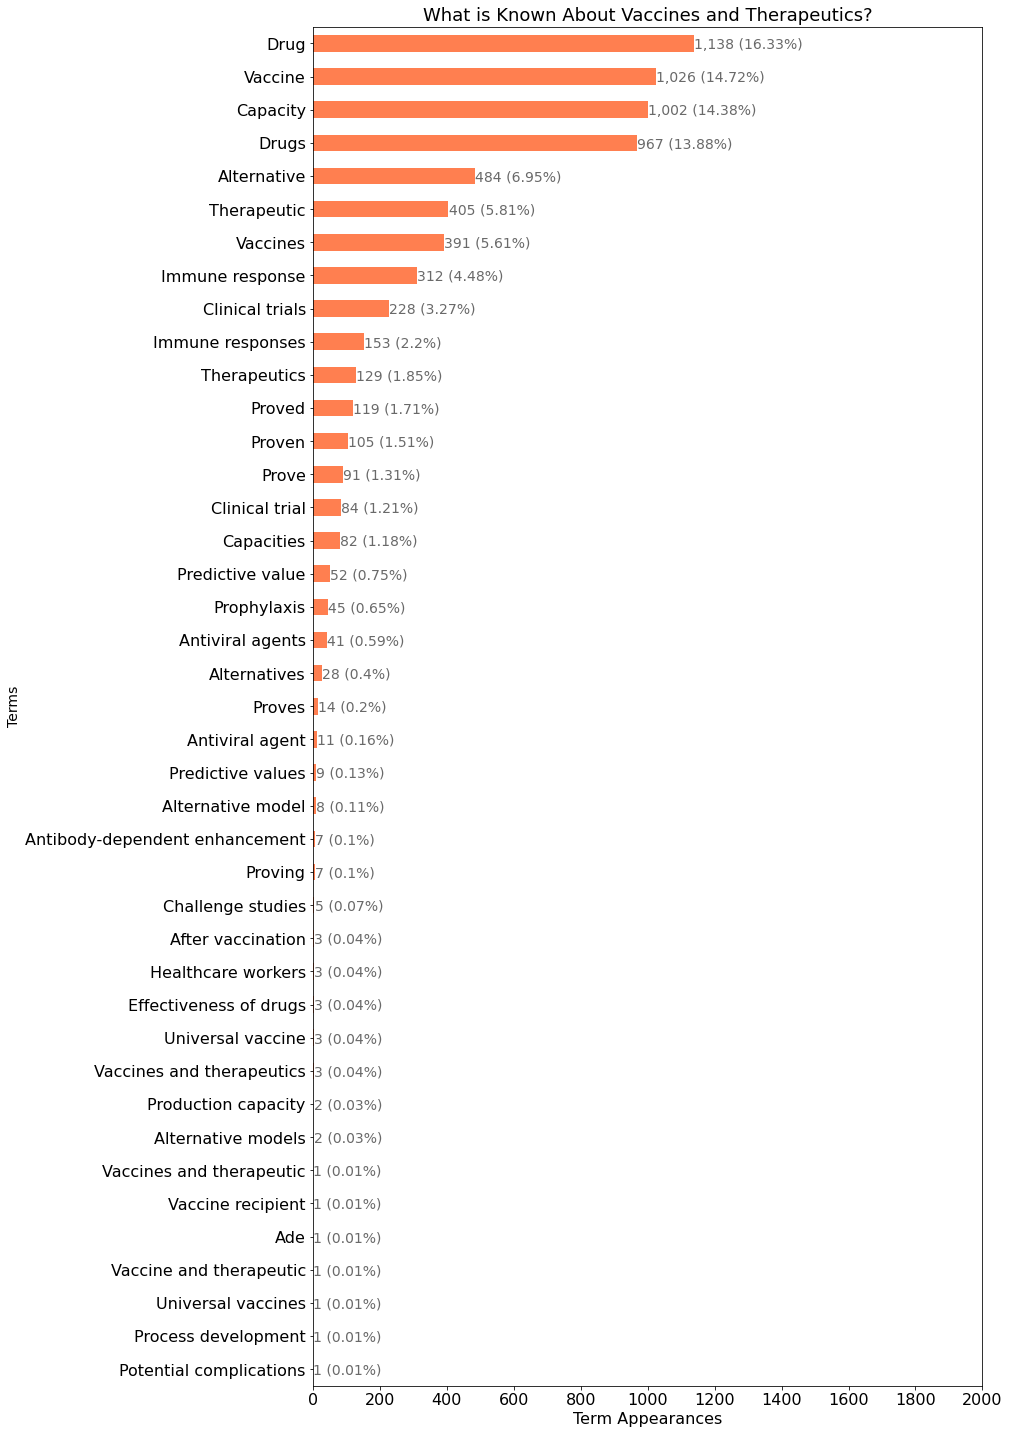

In [58]:
#Display a bar graph and a word cloud with the totals of findings  by key term.
ax = cnt_s.plot(kind='barh', figsize=(12,25), 
                legend=False, color="coral", 
                fontsize=16)
ax.set_alpha(0.8)
ax.set_title("What is Known About Vaccines and Therapeutics?",
             fontsize=18)
ax.set_xlabel("Term Appearances", fontsize=16);
ax.set_ylabel("Terms", fontsize=14);
ax.set_xticks([0,200,400,600,800,1000,1200,1400,1600,1800,2000])

# Create a list to collect the plt.patches data
totals = []

# Fill totals list
for i in ax.patches:
    totals.append(i.get_width())

total = sum(totals)

# Set bar labels using the list
for i in ax.patches:
    c = i.get_width()
    cnt = f'{c:,} '
    pct = str(round((c/total)*100, 2)) + '%'
    pct_f = "(" + pct + ")"
    ax.text(c+.3, i.get_y()+.4, cnt + pct_f, 
            fontsize=14, color='dimgrey')

# Invert graph 
ax.invert_yaxis()

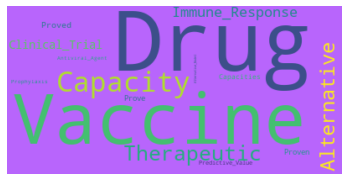

<Figure size 720x576 with 0 Axes>

In [62]:
#Dispalying wordcloud
from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Fill the list of words to show
term_values = ""
for term in findings['term']:
    term_val = str(term).title()
    term_val = term_val.replace(' ','_')
    term_val = term_val.replace('-','_')
    term_values += term_val + ' '

# Generates the wordcloud object
wordcloud = WordCloud(background_color="#B865FC",
                      collocations=False).generate(term_values)


# Display the generated image
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.figure(figsize=((10,8)))
plt.show()